# Modeling Light Echo Evolution

In this tutorial, we will demonstate the creation of light echoes (LEs) from an astrophysical transient (e.g., a supernova). These simulations help us predict how Rubin LSST will detect light echoes for historical transients in our Milky Way and nearby galaxies.

To keep the exercise simple, we assume:
- Brightness of LEs is proportional to local dust density (from a 2D dust map);

- Distances between the source and dust are computed as Euclidean distances in 2D (not full 3D geometry).

Key equation:

$F_{LE} = a_{dust} * F_{model} (t + \Delta T) + F_{background}$

Workflow

- load a supernova light curve and create a model
- load dust image from Spitzer telescope; normalize dust intensity to represent;
- compute phase difference dT based on distances to the source
- create echo image
- make an animation
- extract light curves at a fixed point: pick a position and track its brightness over time
- explore how the appearance of the LEs changes for short and long transients


In [1]:
#from google.colab import drive
#drive.mount('/drive', force_remount=True)


In [2]:
#cd 'drive/MyDrive/ztf_summer_school_2025/day4/le_study/LEsim.ipynb'

In [3]:
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import astropy.wcs
from astropy import units as u
from astropy.coordinates import SkyCoord


In [4]:
#!pip install reproject


In [5]:
from reproject import reproject_interp
# used to reproject image between different coordinates system

In [6]:
# load fits image
def get_imgarr(fitsfile, idx=0, return_header=False):
    """get image array from fits
    Parameters:
        fitsfile: FITS file
        idx: hdul index in FITS
        return_header: boolean, return FITS header
    """
    from astropy.io import fits
    hdul = fits.open(fitsfile)
    item = hdul[idx]
    if item.is_image:
        header = item.header
        # invert y to be same as jpg
        #imgarr = item.data[::-1, :]
        imgarr = item.data
        hdul.close()
        if return_header:
            return imgarr, header
        else:
            return imgarr
    else:
        print('not image file')


## load model

load a supernova light curve and create a model

In [7]:
#df_lc = pd.read_csv('2013ab_phot.txt', skiprows=2)
df_lc = pd.read_csv('dataset/LEsim/2014J_phot.txt', skiprows=2)

In [8]:
df_lc

,# FLT,MJD,MAG,MAGERR
0,R,56677.684437,11.393259,0.01
1,R,56678.312051,11.005618,0.01
2,B,56678.869000,12.966000,0.01
3,V,56678.869000,11.721000,0.01
4,I,56678.870000,10.626000,0.01
...,...,...,...,...
774,V,56785.800000,13.829000,0.01
775,B,56798.900000,15.571000,0.01
776,I,56798.900000,13.078000,0.01
777,R,56798.900000,13.545000,0.01


In [9]:
# convert mag to flux
def mag2flux(m, m0):
    return 10**(-0.4 * (m - m0))


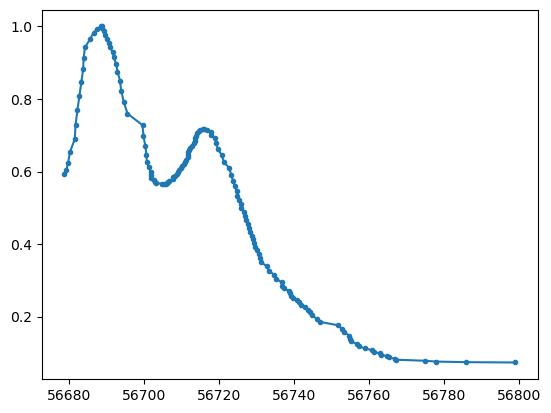

In [10]:
x = df_lc [df_lc['# FLT'] == 'I']['MJD']
y = df_lc [df_lc['# FLT'] == 'I']['MAG']

y = mag2flux(y, 8.9)

y = sp.ndimage.gaussian_filter1d(y, 4, output=y)

# normalize flux

y = y/np.max(y)

plt.plot(x, y, '.-')

#plt.gca().invert_yaxis()


In [11]:
lc = sp.interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value=0)


Text(0, 0.5, 'flux')

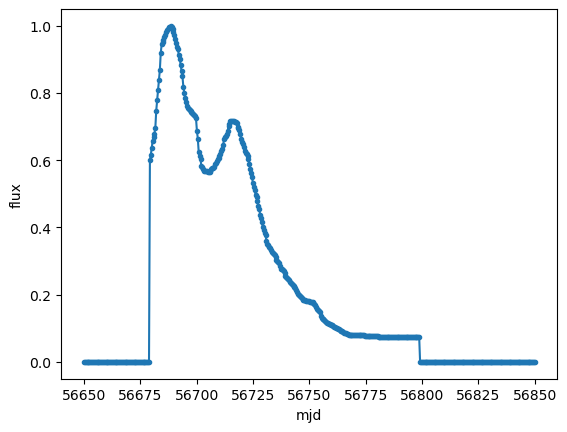

In [12]:
t = np.linspace(56650, 56850, 500)

f = lc(t)

plt.plot(t, f, '.-')

plt.xlabel('mjd')
plt.ylabel('flux')


## Load dust image


download [Spitzer data](https://drive.google.com/file/d/14Va35XBkqaa3y0K8fC_XaQWPeSumR4x5/view?usp=sharing) to ``dataset/LEsim/``


In [13]:
img54, header54= get_imgarr(fitsfile="dataset/LEsim/ec0915.190222.826208_ooi_i_v1_N22_140329.296582_ooi_i_v1_N22.diff.fits",
                        idx=0, return_header=True)

img_spitzer, header_spitzer= get_imgarr(fitsfile="dataset/LEsim/SPITZER_I4_12914176_0000_6_E8351909_maic.fits",
                        idx=0, return_header=True)

# project to same coordinates
img_spitzer_proj54, footprint_spitzer_proj54 = reproject_interp((img_spitzer, header_spitzer), header54)

wcs54 = astropy.wcs.WCS(header54)



In [14]:
# cut the Spitzer image to where LEs has been observed, can use any part in the exercise

spitzer_cutout = img_spitzer_proj54[764:1492, 3470:4153]

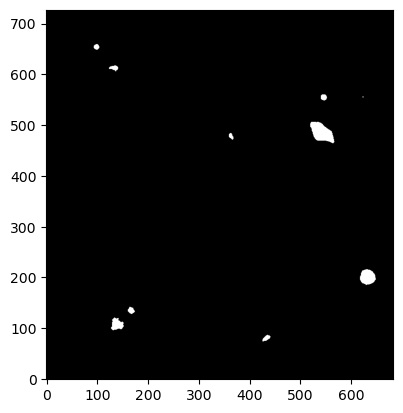

In [15]:
# mask for stars
mask = spitzer_cutout>70
plt.imshow(mask, origin='lower', cmap='gray')

In [16]:
# normalize the dust density

a_norm = spitzer_cutout.copy()

a_norm[a_norm>70] = 0
a_norm = a_norm/70

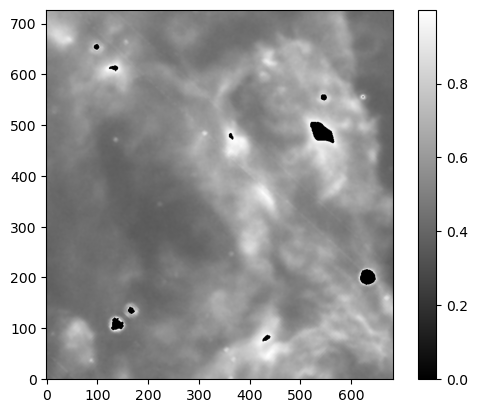

In [17]:
plt.imshow(a_norm, origin='lower', cmap='gray')
plt.colorbar()

## compute phase difference dT

In [18]:
(size_y, size_x) = spitzer_cutout.shape
# Create arrays for x and y
x = np.arange(size_x)
y = np.arange(size_y)

# Create a meshgrid for x and y
Y, X = np.meshgrid(y, x, indexing='ij')


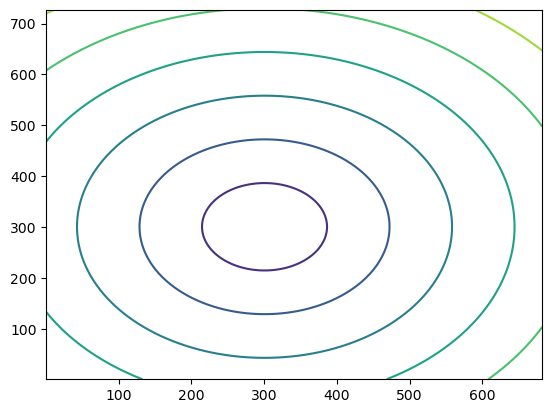

In [19]:
#dT = np.sqrt((X+200)**2 + (Y-3000)**2) - np.sqrt((400+200)**2 + (400-3000)**2)

# the position of the source
x_source = 300
y_source = 300

dT = np.sqrt((X-x_source) ** 2 + (Y-y_source)**2)

dT = dT / dT.max()

# adjust the phase seperation
dT = dT * 100
plt.contour(dT, origin='lower',)


## create the echo image by combining dust map with the light curve model




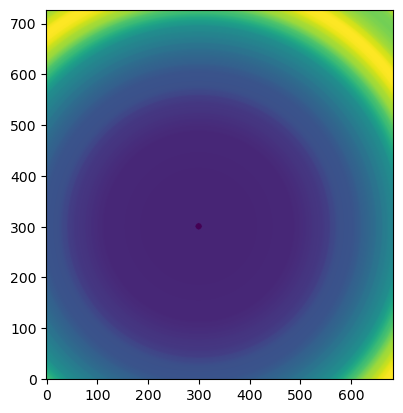

In [20]:
T0 = 56680

plt.imshow( lc( T0 - dT + 120) , origin='lower', )


### consider dust and background

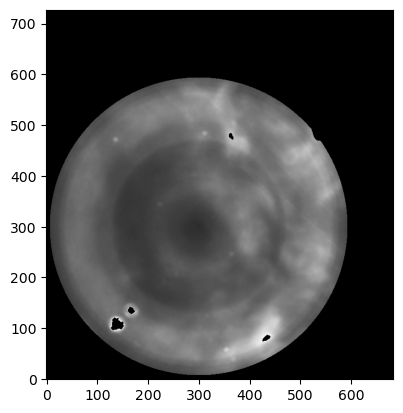

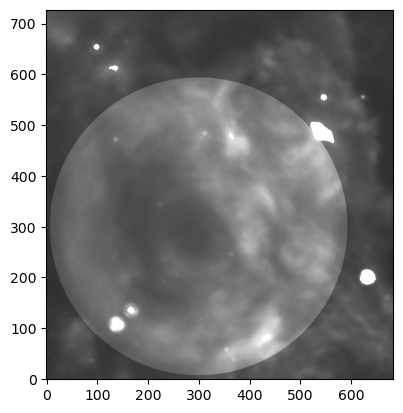

In [21]:
# add backgrond

f_bg = a_norm * 1

# plot images
#t_tmpl = 56765  # template time

T = 50

f_le = lc( T0 - dT + T) * a_norm

f_le_bg = f_le + f_bg  # tmpl image
f_le_bg[mask] = f_le_bg.max()  # set satulated star

plt.imshow(f_le, origin='lower', vmin=0, vmax=f_le.max(), cmap='gray')

plt.figure()
plt.imshow(f_le_bg, origin='lower', vmin=0, vmax=f_le_bg.max(), cmap='gray')



## run for all time phase

In [22]:

t = np.linspace(T0, T0+200, 500)
f = lc(t)

F_le = []
for ti in t:
    # image
    f_le = lc(ti-dT) * a_norm
    f_le_bg = f_ec + f_bg
    f_le_bg[mask] = f_le_bg.max()

    F_le.append(f_le)
    print(ti)

NameError: name 'f_ec' is not defined

In [ ]:
F_le_stack = np.stack(F_le, axis=-1)

### extract the light curves at two different locations, how are they related

In [ ]:
x_pix = 600
y_pix = 100
lc_pix = F_le_stack[y_pix, x_pix, :]

plt.plot(lc_pix)

x_pix = 100
y_pix = 700
lc_pix = F_le_stack[y_pix, x_pix, :]

plt.plot(lc_pix)

### can we get the light curve from single phase image?

In [ ]:
### implement here



## Animate

make an animation of the evolution of the LE we created above[link text](https://)

## change the time scale of the transient, how the appearance of the LEs changes for short and long transients